<a href="https://colab.research.google.com/github/adhilcodes/compressive-strength---regression/blob/main/Regression_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement: Prediction of concrete compressive strength

Data description:

* cement: The amount of cement in the mixture.
* slag: The amount of blast furnace slag in the mixture.
* flyash: The amount of fly ash in the mixture.
* water: The amount of water in the mixture.
* superplasticizer: The amount of superplasticizer in the mixture.
* coarseaggregate: The amount of coarse aggregate in the mixture.
* fineaggregate: The amount of fine aggregate in the mixture.
* age: The age of the concrete (in days) at the time of testing.
* csMPa: The concrete compressive strength (in MPa), which is the * target variable you want to predict.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('/content/Concrete_Data_Yeh.csv')
print(data.shape)
data.head()

(1030, 9)


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
data.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'csMPa'],
      dtype='object')

In [4]:
# Checking for null values
data.isnull().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

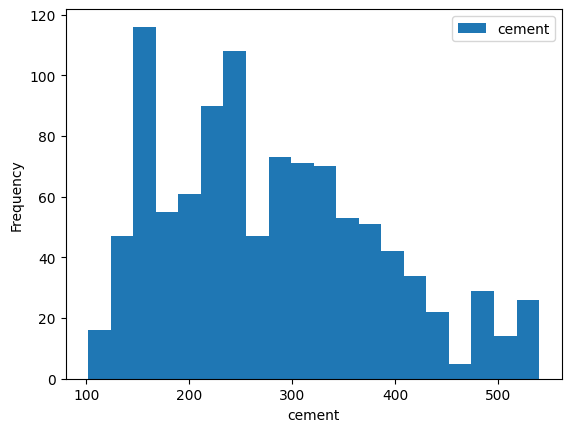

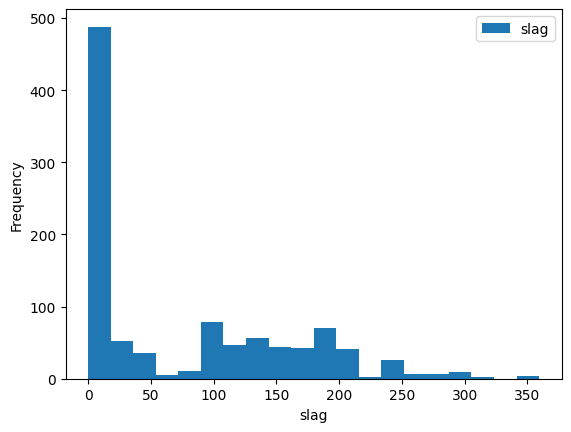

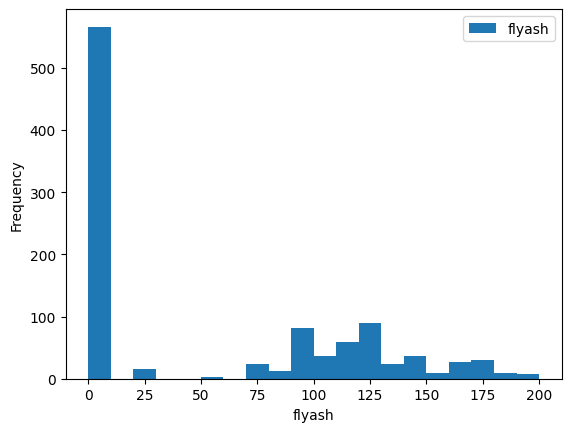

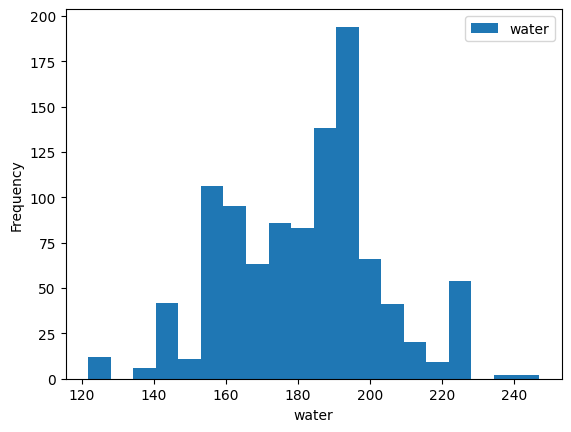

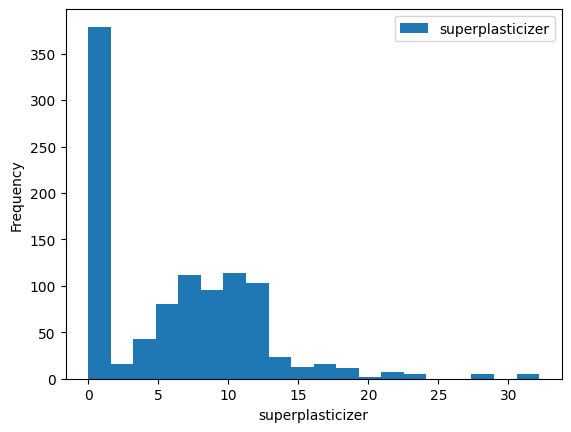

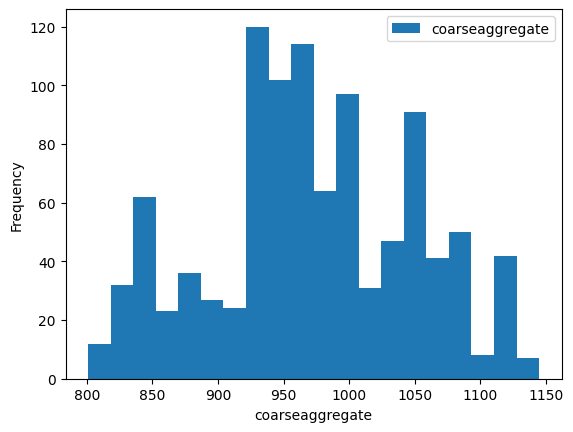

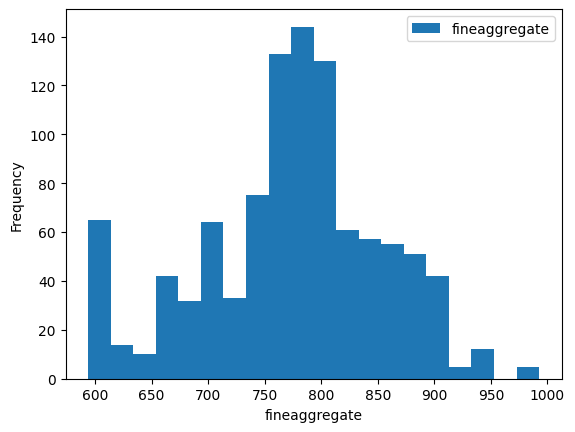

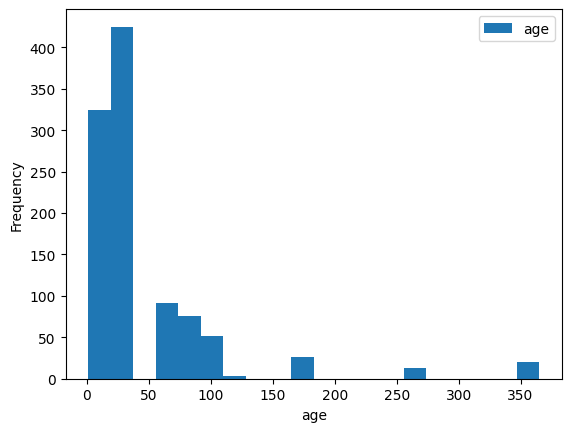

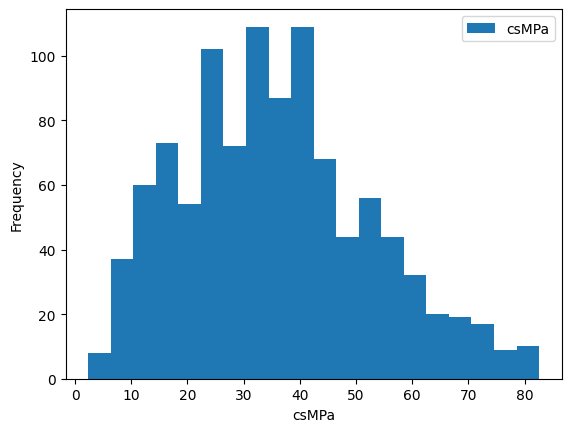

In [5]:
# Plotting histograms for all features
for feature in data.columns:
    plt.hist(data[feature],bins=20, label=feature)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

Some features(fineaggregate, water, cement) slightly follows a normal distribution, which may not require extensive preprocessing.

### Plotting correlation matrix analyzing

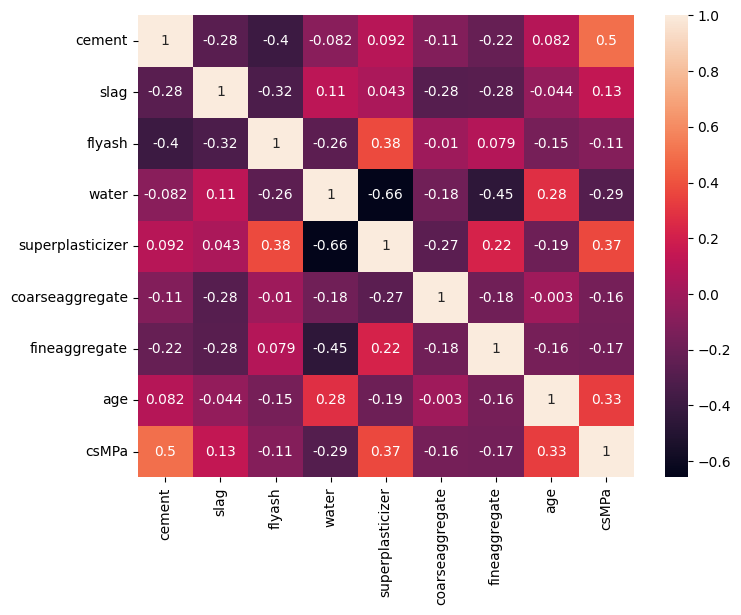

In [6]:
# plotting correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot= True)
plt.show()

In [7]:
# Finding pair of features with correlation greater than 0.4

corr_ = data.corr()
z = [[str(i),str(j)] for i in corr_.columns for j in corr_.columns if(corr_.loc[i,j]>abs(0.4)) & (i!=j)]
z,len(z)/2

([['cement', 'csMPa'], ['csMPa', 'cement']], 1.0)

In [8]:
# correlation of all features with targer('csMPa')
corr_matrix = data.corr(numeric_only=True)

corr_with_price = corr_matrix['csMPa']
sorted_correlations = corr_with_price.sort_values(ascending=False)
sorted_correlations

csMPa               1.000000
cement              0.497832
superplasticizer    0.366079
age                 0.328873
slag                0.134829
flyash             -0.105755
coarseaggregate    -0.164935
fineaggregate      -0.167241
water              -0.289633
Name: csMPa, dtype: float64

* 'cement' have greater correlation(0.49) with 'csMPa'

* 'superplasticizer', 'age' and 'slag' also have good correlation with 'csMPa'

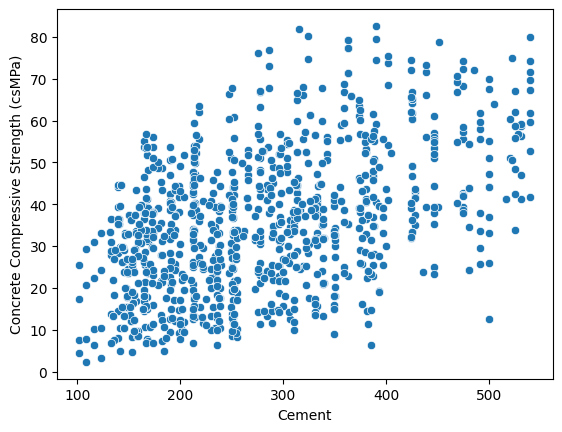

In [9]:
# Scatter plot of 'cement' vs. 'csMPa'
sns.scatterplot(data=data, x='cement', y='csMPa')
plt.xlabel('Cement')
plt.ylabel('Concrete Compressive Strength (csMPa)')
plt.show()

The wider spread data points indicates a greater variability in between 'cement' and 'csMPa.So 'cement' alone does not entirely determine the 'csMPa' some other factors also influencing to find the compressive strength of concrete.

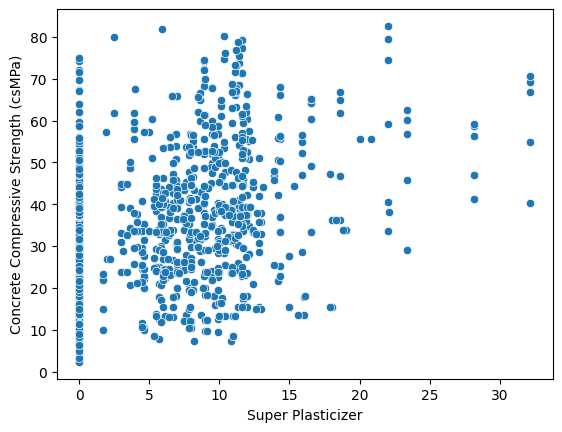

In [10]:
# Scatter plot of 'superplasticizer' vs. 'csMPa'
sns.scatterplot(data=data, x='superplasticizer', y='csMPa')
plt.xlabel('Super Plasticizer')
plt.ylabel('Concrete Compressive Strength (csMPa)')
plt.show()

* The wide spread indicates 'superplasticizer' alone is not a strong predictor of 'csMPa,'
* In the left clustering of some points indicates presence of similar 'superplasticizer' values with different 'csMPa'

### Finding and removing outliers

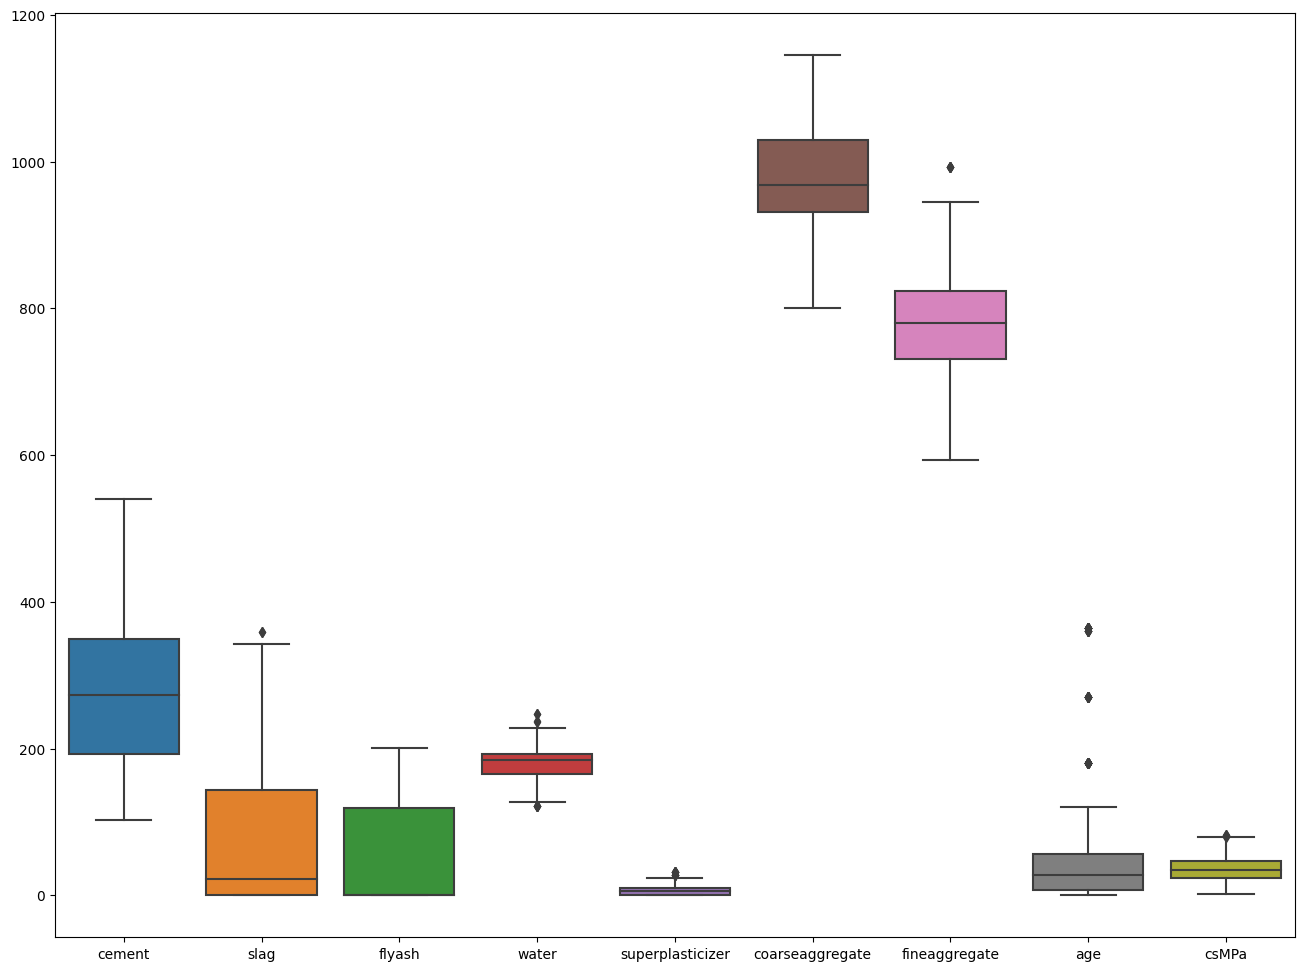

In [11]:
plt.figure(figsize=(16, 12))
sns.boxplot(data)
plt.show()

In [12]:
def iqr_function(data):
    outlier_indices = []

    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_band = Q1 - 1.5 * IQR
        upper_band = Q3 + 1.5 * IQR

        outliers = data[(data[col] < lower_band) | (data[col] > upper_band)]

        if not outliers.empty:
            outlier_indices.extend(outliers.index.tolist())

    return list(set(outlier_indices))


outlier_indices = iqr_function(data)
print(outlier_indices)

[0, 2, 3, 4, 6, 12, 17, 19, 20, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 39, 553, 41, 42, 43, 559, 47, 50, 51, 56, 58, 60, 61, 63, 64, 65, 66, 74, 76, 79, 603, 604, 97, 609, 99, 610, 102, 615, 616, 619, 620, 621, 622, 120, 122, 125, 143, 145, 148, 153, 166, 168, 171, 181, 224, 225, 226, 227, 228, 755, 756, 762, 768, 769, 791, 792, 794, 795, 797, 798, 813, 814, 820, 823, 862, 873, 381, 936, 1019]


In [13]:
data_ = data.drop(outlier_indices)
print(data.shape, data_.shape)

(1030, 9) (941, 9)


Adding a new feature 'cement_water_ratio' which is the ratio of the amount of cement to the amount of water

    cement_water_ratio = cement / water

In [14]:
data_['cement_water_ratio'] = data_['cement'] / data_['water']
print(data_.shape)
data_.head()

(941, 10)


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa,cement_water_ratio
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,3.333333
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03,1.166667
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45,1.666667
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,1.166667
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29,2.083333


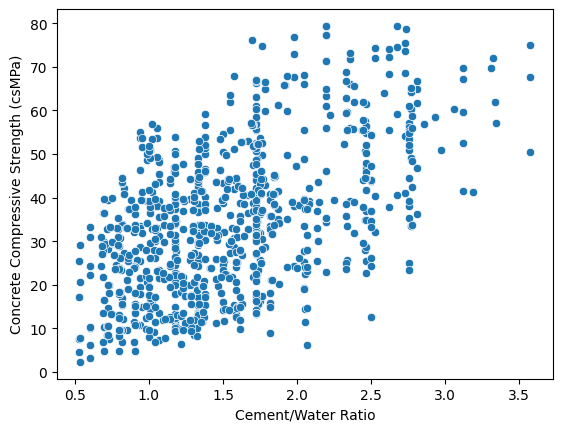

In [15]:
# Scatter plot of 'cement_water_ratio' vs. 'csMPa'
sns.scatterplot(data=data_, x='cement_water_ratio', y='csMPa')
plt.xlabel('Cement/Water Ratio')
plt.ylabel('Concrete Compressive Strength (csMPa)')
plt.show()

In [16]:
correlation_cw = data_['cement_water_ratio'].corr(data_['csMPa'])
print("Correlation with csMPa (Cement/Water Ratio):", correlation_cw)

Correlation with csMPa (Cement/Water Ratio): 0.5565342379304046


In [17]:
corr_matrix = data_.corr()

corr_with_price = corr_matrix['csMPa']
sorted_correlations = corr_with_price.sort_values(ascending=False)
sorted_correlations

csMPa                 1.000000
cement_water_ratio    0.556534
age                   0.517506
cement                0.476763
superplasticizer      0.402702
slag                  0.141416
flyash               -0.054794
fineaggregate        -0.156866
coarseaggregate      -0.168207
water                -0.369219
Name: csMPa, dtype: float64

The new feature have a good correlation with the target variable comparing to other features

### Standardizing values using StandardScaler

In [18]:
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(data_)

data_scaled = pd.DataFrame(data_scaled, columns=[col for col in data_.columns])
print(data_scaled.shape)
data_scaled.head()

(941, 10)


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa,cement_water_ratio
0,2.594760,-0.855740,-0.901915,-0.993547,-0.702013,1.033328,-1.340064,-0.153317,1.628245,2.892752
1,-0.095894,0.465049,-0.901915,2.528520,-1.170347,-0.551615,-1.420026,2.018806,0.732186,-0.622137
2,1.023575,0.244917,-0.901915,2.528520,-1.170347,-0.551615,-2.432885,-0.153317,0.094210,0.188992
3,-0.095894,0.465049,-0.901915,2.528520,-1.170347,-0.551615,-1.420026,-0.153317,0.661031,-0.622137
4,1.956466,-0.855740,-0.901915,2.528520,-1.170347,-0.551615,-2.432885,-0.153317,0.265463,0.864932


### Preparing data for training process

In [19]:
X = data_scaled.drop('csMPa', axis=1)
y = data_scaled['csMPa']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=24)

### Training the model

### Linear Regression

In [21]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
lr_pred = linear_reg.predict(X_test)

### Polynomial Regression


In [22]:
# Apply polynomial to the features
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# regressor
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

poly_pred = poly_model.predict(X_test_poly)

### Lasso Regression



In [23]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

In [24]:
# Polynomial Lasso Regression

lasso_model_poly = Lasso(alpha=0.1)
lasso_model_poly.fit(X_train_poly, y_train)
lasso_pred_poly = lasso_model_poly.predict(X_test_poly)

## Model Evaluation

In [44]:
def evaluate_model(y_true, y_pred, model_name):

    r2_sc = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    print("{} - R2 value: {}".format(model_name, round(r2_sc,2)))
    print("{} - Mean Squared Error (MSE): {}".format(model_name, round(mse,2)))
    print("{} - Root Mean Squared Error (MSE): {}".format(model_name, round(rmse,2)), "\n")



evaluate_model(y_test, lr_pred, "Linear Regression")
evaluate_model(y_test, poly_pred, "Polynomial Regression")
evaluate_model(y_test, lasso_pred, "Lasso Regression")
evaluate_model(y_test, lasso_pred_poly, "Polynomial Lasso Regression")

Linear Regression - R2 value: 0.79
Linear Regression - Mean Squared Error (MSE): 0.25
Linear Regression - Root Mean Squared Error (MSE): 0.5 

Polynomial Regression - R2 value: 0.87
Polynomial Regression - Mean Squared Error (MSE): 0.15
Polynomial Regression - Root Mean Squared Error (MSE): 0.38 

Lasso Regression - R2 value: 0.71
Lasso Regression - Mean Squared Error (MSE): 0.33
Lasso Regression - Root Mean Squared Error (MSE): 0.57 

Polynomial Lasso Regression - R2 value: 0.73
Polynomial Lasso Regression - Mean Squared Error (MSE): 0.3
Polynomial Lasso Regression - Root Mean Squared Error (MSE): 0.55 



### My observations:

* Polynomial regression model captures non-linear relationships in the data better than linear regression model.

*  Lasso regression models performance worse than the linear regression model, it may be due to the L1 regularization of Lasso, which may have removed important features.

* Adding polynomial features with Lasso regularization has provided better results

* Combination of polynomial and Lasso regression gives better performance.

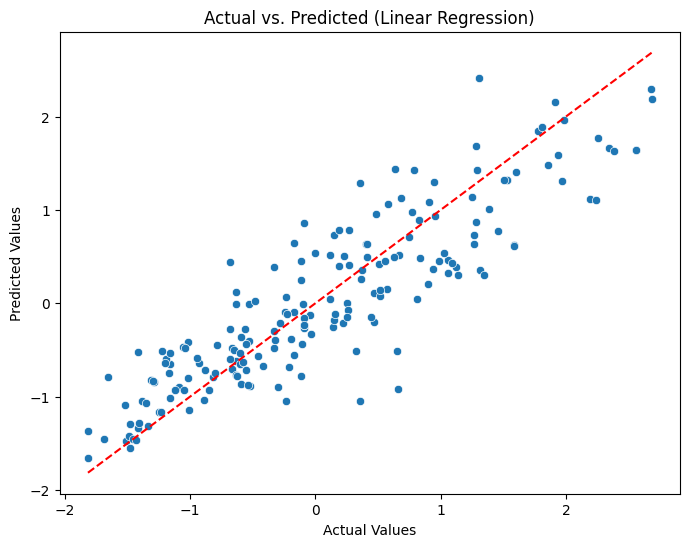

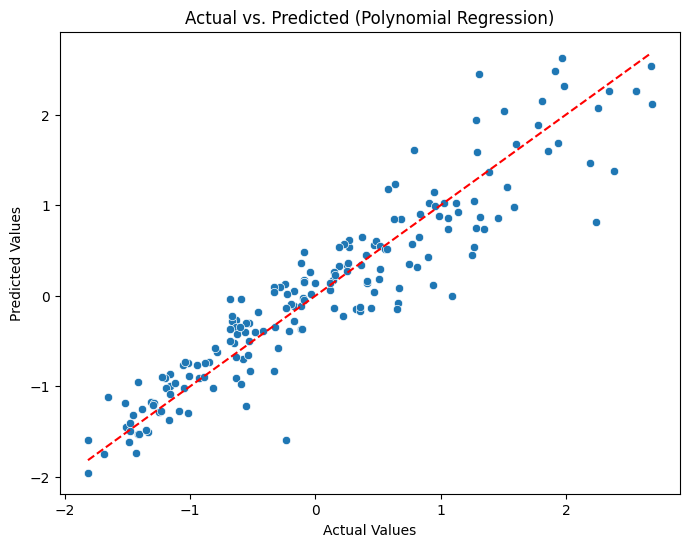

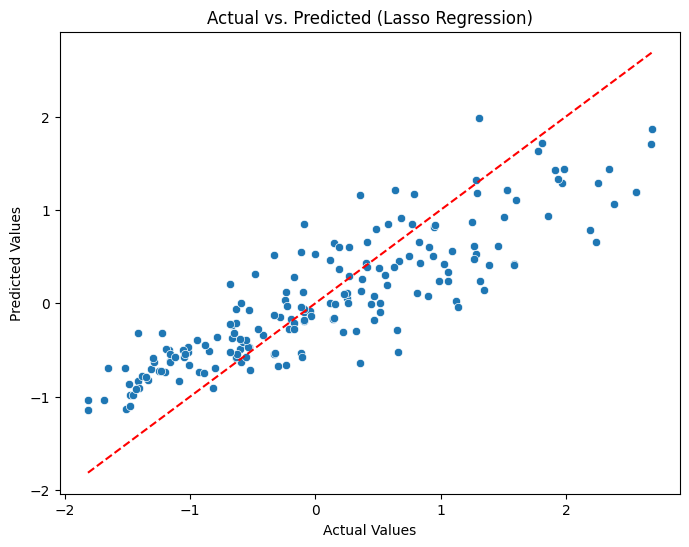

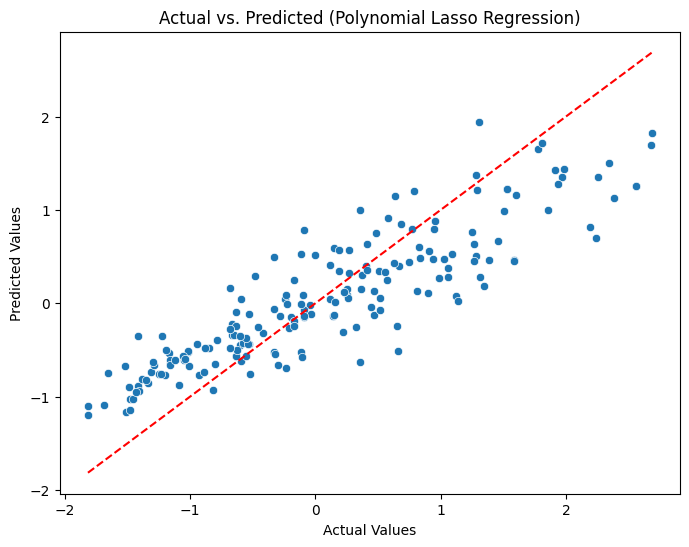

In [26]:
def plot_actual_vs_predicted(y_true, y_pred, model_name):

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted ({model_name})')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    print(" ")
    plt.show()


plot_actual_vs_predicted(y_test, lr_pred, 'Linear Regression')
plot_actual_vs_predicted(y_test, poly_pred, 'Polynomial Regression')
plot_actual_vs_predicted(y_test, lasso_pred, 'Lasso Regression')
plot_actual_vs_predicted(y_test, lasso_pred_poly, 'Polynomial Lasso Regression')

Data points clustering closely around the diagonal line, which indicates the good model perfomance

### Hyperparameter tunig Polynomial Lasso Regression

In [47]:
# range of alpha values to search

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}

grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 5.588e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 5.909e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 5.639e

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='neg_mean_squared_error')

In [48]:
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha value from the grid search {best_alpha} \n")

Best alpha value from the grid search 0.001 



In [49]:
# new Lasso model with the best alpha=0.001

best_lasso_model_poly = Lasso(alpha=best_alpha)
best_lasso_model_poly.fit(X_train_poly, y_train)
best_lasso_pred_poly = best_lasso_model_poly.predict(X_test_poly)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 7.234e-02
  model = cd_fast.enet_coordinate_descent(


In [50]:
# Evaluate the model with the best alpha
mse_best = mean_squared_error(y_test, best_lasso_pred_poly)

evaluate_model(y_test, best_lasso_pred_poly, "Polynomial Lasso Regression - alpha=0.001")

Polynomial Lasso Regression - alpha=0.001 - R2 value: 0.87
Polynomial Lasso Regression - alpha=0.001 - Mean Squared Error (MSE): 0.14
Polynomial Lasso Regression - alpha=0.001 - Root Mean Squared Error (MSE): 0.38 



After choosing best value for alpha model perfomance got improved

### Trying SVM

In [51]:
svm = SVR()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

In [52]:
evaluate_model(y_test, svm_pred, "SVM")

SVM - R2 value: 0.88
SVM - Mean Squared Error (MSE): 0.13
SVM - Root Mean Squared Error (MSE): 0.37 



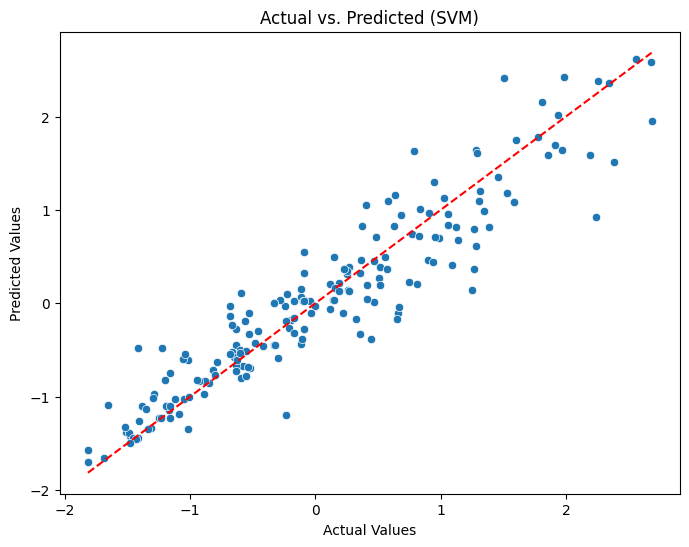

In [53]:
plot_actual_vs_predicted(y_test, svm_pred, 'SVM')

SVM on polynomial regression

In [54]:
svm.fit(X_train_poly, y_train)
svm_pred_poly = svm.predict(X_test_poly)

In [55]:
evaluate_model(y_test, svm_pred_poly, "Polynomial SVM")

Polynomial SVM - R2 value: 0.88
Polynomial SVM - Mean Squared Error (MSE): 0.14
Polynomial SVM - Root Mean Squared Error (MSE): 0.37 



#### Hyperparameter tuning SVM

In [56]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],  # kernel parameter
    'C': [0.01, 0.1, 1, 10],            # Regularization parameter
    'epsilon': [0.01, 0.1, 1]           # Epsilon parameter for SVR
}


svm = SVR()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'epsilon': [0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='neg_mean_squared_error')

In [57]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}


In [58]:
# Trying best hyperparameters

best_svm = SVR(kernel=best_params['kernel'], C=best_params['C'], epsilon=best_params['epsilon'])
best_svm.fit(X_train, y_train)
svm_pred_best_para = best_svm.predict(X_test)

In [59]:
evaluate_model(y_test, svm_pred_best_para, "SVM - Hyperparameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}")

SVM - Hyperparameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'} - R2 value: 0.92
SVM - Hyperparameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'} - Mean Squared Error (MSE): 0.09
SVM - Hyperparameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'} - Root Mean Squared Error (MSE): 0.31 



Got a much more better result:

* R2 value: 0.92
* Mean Squared Error (MSE): 0.09
* Root Mean Squared Error (MSE): 0.31

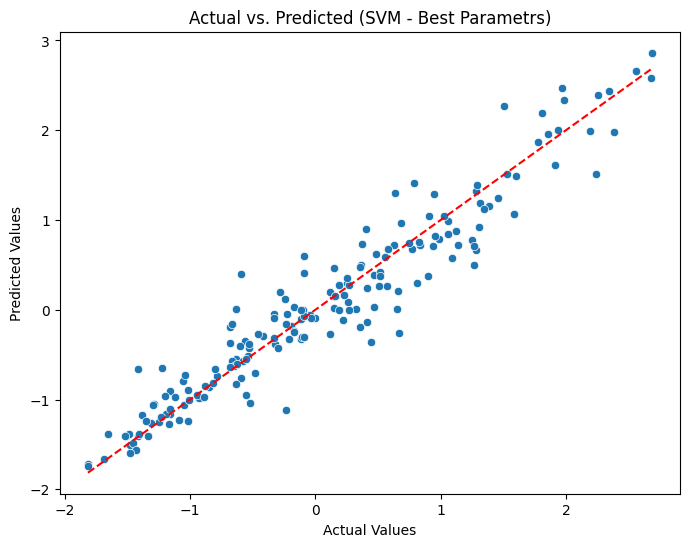

In [60]:
plot_actual_vs_predicted(y_test, svm_pred_best_para, 'SVM - Best Parametrs')

### Summary

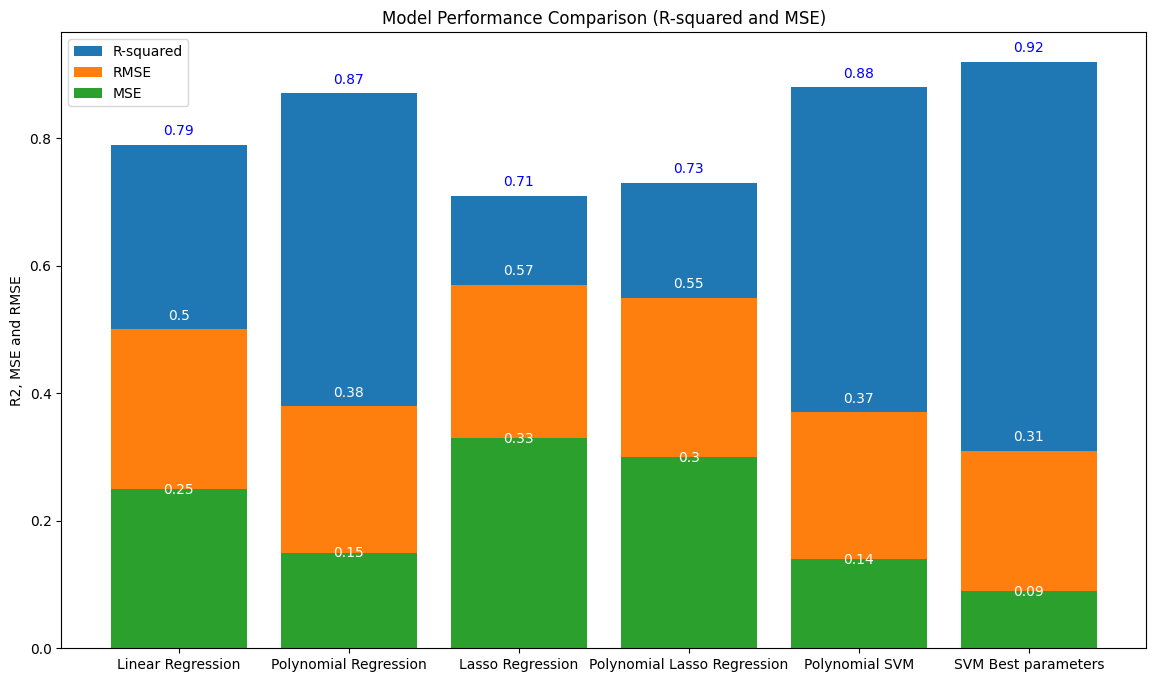

In [66]:
model_names = ["Linear Regression", "Polynomial Regression", "Lasso Regression", "Polynomial Lasso Regression", "Polynomial SVM", "SVM Best parameters"]
r2_varlues = [0.79, 0.87, 0.71, 0.73, 0.88, 0.92]
mse_values = [0.25, 0.15, 0.33, 0.3, 0.14, 0.09]
rmse_values = [0.5, 0.38, 0.57, 0.55, 0.37, 0.31]

plt.figure(figsize=(14, 8))
plt.bar(model_names, r2_values, label='R-squared')
plt.bar(model_names, rmse_values, label='RMSE')
plt.bar(model_names, mse_values, label='MSE')
plt.ylabel('R2, MSE and RMSE')
plt.title('Model Performance Comparison (R-squared and MSE)')

for i in range(len(model_names)):
    plt.text(i, r2_values[i] + 0.01, r2_values[i], ha='center', va='bottom', color='blue')

for i in range(len(model_names)):
    plt.text(i, rmse_values[i] + 0.01, rmse_values[i], ha='center', va='bottom', color='white')

for i in range(len(model_names)):
    plt.text(i, mse_values[i] + 0.01, mse_values[i], ha='center', va='top', color='white')

plt.legend()
plt.show()


* The SVM model with hyperparameter tuning emerges as the preferred choice for accurately predicting concrete compressive strength. It achieved the highest R-squared (R^2) value of 0.92, the lowest Mean Squared Error (MSE) of 0.09 and lowest Root Mean Squared Error (MSE) of 0.31 on the test data.

* Polynomial Regression also have a strong predictive performance with an R^2 value of 0.87 and an MSE of 0.15. This suggests that the relationship between the independent and dependent features may have some non-linear characteristics that Polynomial Regression captures well.

* From the results it seems like Lasso regularization may have overly penalized some features, leading to suboptimal predictions.

* Linear Regression achieved a reasonable value for R^2 value of 0.79 and it had a higher MSE of 0.25 compared to other algorithms, which indicates that it may not capture some of the non-linear relationships present in the data.